In [1]:
1000# Utils
import os, sys, re, time, gc, types, string, warnings, inspect,  unicodedata, unidecode

#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle
import re, sys

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD


#plt.style.use('fivethirtyeight')
from nltk.stem.snowball import SnowballStemmer

#Carga stop word
nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')

# punkt:  módulo contiene modelos para la tokenización de textos
nltk.download('punkt')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/root/anaconda3/envs/tensorflow_cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
root_path = "../"
path_data_clean = root_path + "data/clean/"
path_model = root_path + 'models/'
features_path = root_path + 'data/features/'
model_name = "tfidf10000_svd1000"
path_model += model_name

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

falta agregar data v2 y beatiful soup para limpiar html en data 2

In [3]:
dfNoticias = pd.read_pickle(path_data_clean + "/dfNoticiasCleanV2.p")


In [4]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
0,"\nLa presidenta argentina, Cristina Fernández,...",2013-11-20,21:37,20131120214139,\nEste fue el primer acto público de la mandat...,mundo,None,None,None,None,None,argentina,None,None,\nPresidenta argentina tomó juramento a tres n...,fid_noticia
1,\nPor problemas de agenda de la jueza del Trib...,2013-11-20,17:09,20131120164254,\nAudiencia se realizará el próximo lunes 2 de...,pais,None,None,None,None,None,region de la araucania,None,None,\nNuevamente se postergó preparación del juici...,fid_noticia
2,"\nEl presidente uruguayo, José Mujica, sufre u...",2013-11-20,12:45,20131120124736,"\nPresidente uruguayo está afectado por un ""es...",mundo,None,None,None,None,None,uruguay,None,None,\nResfrío que afecta a José Mujica obligó a su...,fid_noticia
4,\nEl Reino Unido considera que el Ejecutivo es...,2013-11-20,11:43,20131120114123,\nGobierno hispano ha ejercido medidas de pres...,mundo,None,None,None,None,None,europa,None,None,\nReino Unido arremete contra España ante incu...,fid_noticia
5,\nFuncionarios municipales de Santiago y otras...,2013-11-20,12:44,20131120124031,\nUfemuch desconoce acuerdo con el Gobierno pa...,pais,None,None,gremios,None,None,trabajo,None,None,\nFuncionarios municipales de Santiago siguen ...,fid_noticia


# pre procesing



In [5]:
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Tema"] = []
_map["Subtema"] = []

count = 0
for index, row in dfNoticias.iterrows():    
    _map["Cuerpo"].append(row["Cuerpo"]) 
    _map["Seccion"].append(row["Seccion_1"])
    _map["Tema"].append(row["Tema_1"])
    _map["Subtema"].append(row["Subtema_1"])

df = pd.DataFrame(_map)
# Elimino clase corporativo, muy pocos ejemplos
df = df[df.Seccion != "corporativo"]

    
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y1 = df['Seccion'].reset_index(drop=True)
y2 = df['Tema'].reset_index(drop=True)
y3 = df['Subtema'].reset_index(drop=True)


In [6]:
secciones=y1.unique()
dic={}
for i,seccion in enumerate(secciones):
    dic[seccion]=i
labels=y1.apply(lambda x:dic[x])

# Pre Procesing

In [7]:

def normalize_text(text):
    """ Funcion de normalizacion """    
    # split into words
    text = text.lower()
    
    tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False)
 
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
    words = [word for word in stripped if word.isalpha()]
    
    # stop word and remove accent
    def strip_accents(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    stop_words = set(spanish_stopwords)
    words = [strip_accents(w) for w in words if not w in stop_words]
    #return words
    return u" ".join(words)
   





In [8]:
from joblib import Parallel, delayed
import multiprocessing

# what are your inputs, and what operation do you want to 
# perform on each input. For example...
inputs = range(10) 

def processInput(i):
    return i * i
 
num_cores = multiprocessing.cpu_count()
     
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [9]:
type(df)

results = Parallel(n_jobs=num_cores, verbose = 1)(delayed(normalize_text)(i) for i in X_untransformed)
texts = pd.Series(results)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 7515 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 30015 tasks      | elapsed:    8.8s
[Parallel(n_jobs=12)]: Done 61515 tasks      | elapsed:   17.0s
[Parallel(n_jobs=12)]: Done 102015 tasks      | elapsed:   27.6s
[Parallel(n_jobs=12)]: Done 151515 tasks      | elapsed:   40.5s
[Parallel(n_jobs=12)]: Done 210015 tasks      | elapsed:   55.8s
[Parallel(n_jobs=12)]: Done 277515 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 351554 out of 351554 | elapsed:  1.5min finished


In [ ]:
# from gensim.test.utils import common_texts, get_tmpfile
# from gensim.models import Word2Vec
# import gensim


# path = get_tmpfile("/opt/NLP_dev/models/word2vec/sbw_vectors.bin")
# word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

# data split

In [11]:

texts_ = texts.iloc[0:12000]

X_train0 = texts.iloc[0:10000]
y_train0 = labels.iloc[0:10000]

X_test0 = texts.iloc[10000:12000]
y_test0 = labels.iloc[10000:12000]


### Tokenize text of the training data with keras text preprocessing functions ###

In [12]:
NUM_WORDS=20000
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

tokenizer.fit_on_texts(texts_)

sequences_train = tokenizer.texts_to_sequences(X_train0)
sequences_valid=tokenizer.texts_to_sequences(X_test0)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 81940 unique tokens.


In [13]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
y_train = to_categorical(y_train0)
y_val = to_categorical(y_test0)
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)


Shape of X train and X validation tensor: (10000, 1317) (2000, 1317)
Shape of label train and validation tensor: (10000, 8) (2000, 8)


### word embedding ###

In [14]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

#from gensim.models.keyedvectors import KeyedVectors

#word_vectors = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

word2vec_path = "/opt/NLP_dev/models/word2vec/sbw_vectors.bin"
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True) # TRue?

### Without pretrained data we can just initalize embedding matrixs as: ###

In [15]:
from keras.layers import Embedding
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)

# modelo

In [16]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5



inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=8, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = Model(inputs, output)

In [17]:
from keras.callbacks import TensorBoard
import time

tensorboard = TensorBoard(log_dir="logs/{}")

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss')]
model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[EarlyStopping(monitor='val_loss'),tensorboard])  # starts training


Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 196s 20ms/step - loss: 1.8013 - acc: 0.4896 - val_loss: 1.4443 - val_acc: 0.6285
Epoch 2/10
10000/10000 [==============================] - 199s 20ms/step - loss: 1.2561 - acc: 0.6718 - val_loss: 1.1018 - val_acc: 0.7205
Epoch 3/10
10000/10000 [==============================] - 199s 20ms/step - loss: 0.9923 - acc: 0.7887 - val_loss: 0.9075 - val_acc: 0.8200
Epoch 4/10
10000/10000 [==============================] - 202s 20ms/step - loss: 0.8451 - acc: 0.8445 - val_loss: 0.8226 - val_acc: 0.8395
Epoch 5/10
10000/10000 [==============================] - 203s 20ms/step - loss: 0.7620 - acc: 0.8579 - val_loss: 0.7838 - val_acc: 0.8425
Epoch 6/10
10000/10000 [==============================] - 203s 20ms/step - loss: 0.7095 - acc: 0.8678 - val_loss: 0.7499 - val_acc: 0.8465
Epoch 7/10
10000/10000 [==============================] - 203s 20ms/step - loss: 0.6736 - acc: 0.8746 - val_loss: 0.7

In [18]:

y_pred=model.predict(X_val)

In [20]:
y_val_pred_hard = []


for idx,val in enumerate(y_pred):
    tmp = [0]*8
    tmp[np.argmax(val)] = 1
    y_val_pred_hard.append(tmp)    
    

y_true = []
y_pred = []

for idx,val in enumerate(y_val_pred_hard):
    y_pred.append(np.argmax(val))

for idx,val in enumerate(y_val):
    y_true.append(np.argmax(val))    


/root/anaconda3/envs/tensorflow_cpu/lib/python3.5/site-packages/scikitplot/metrics.py:124: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


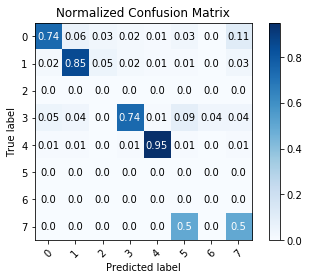

In [21]:
import scikitplot as skplt
import matplotlib.pyplot as plt

#acc = accuracy_score(y_true=y_val, y_pred=y_val_pred)

skplt.metrics.plot_confusion_matrix(y_pred, y_true,normalize='True')
plt.xticks(rotation=45)
plt.show()